# Lyft Perception Challenge

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from loss import LyftLoss
from model import LinkNet
from dataprocess import AugmentColor, ToTensor, LyftDataset

## Parametes setup

In [2]:
epochs = 500
batch = 10
lr = 1e-4
model_path = './data/models/resnet34_test.pth'
encoder='resnet34'
final='softmax'
gamma = 0.35
brightness = 2.0
colors = 0.25
train_dirs = ['data/train/']  # List train dirs here
val_dirs=['data/val/']  # List dirs with validation datasets


hood_path = 'hood.npy'
top = 205
bottom = 525  # bottom-top should be a multiple of 32

## Data loading and augmentation

In [3]:
def show_img(img):
    plt.figure(dpi=300)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

Visualize sample raw train data

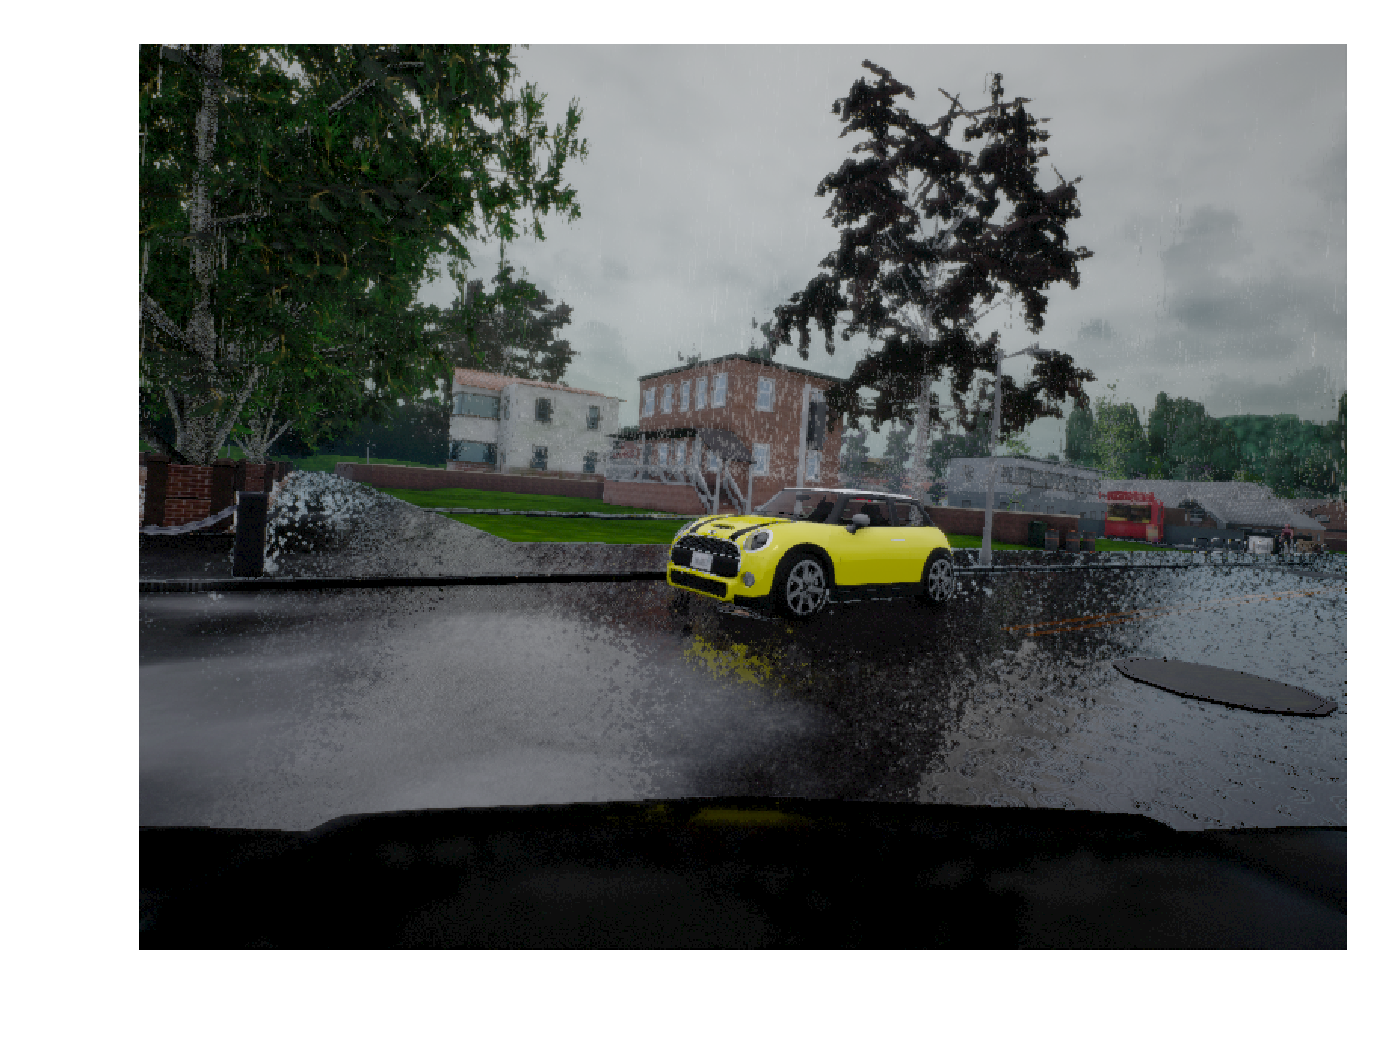

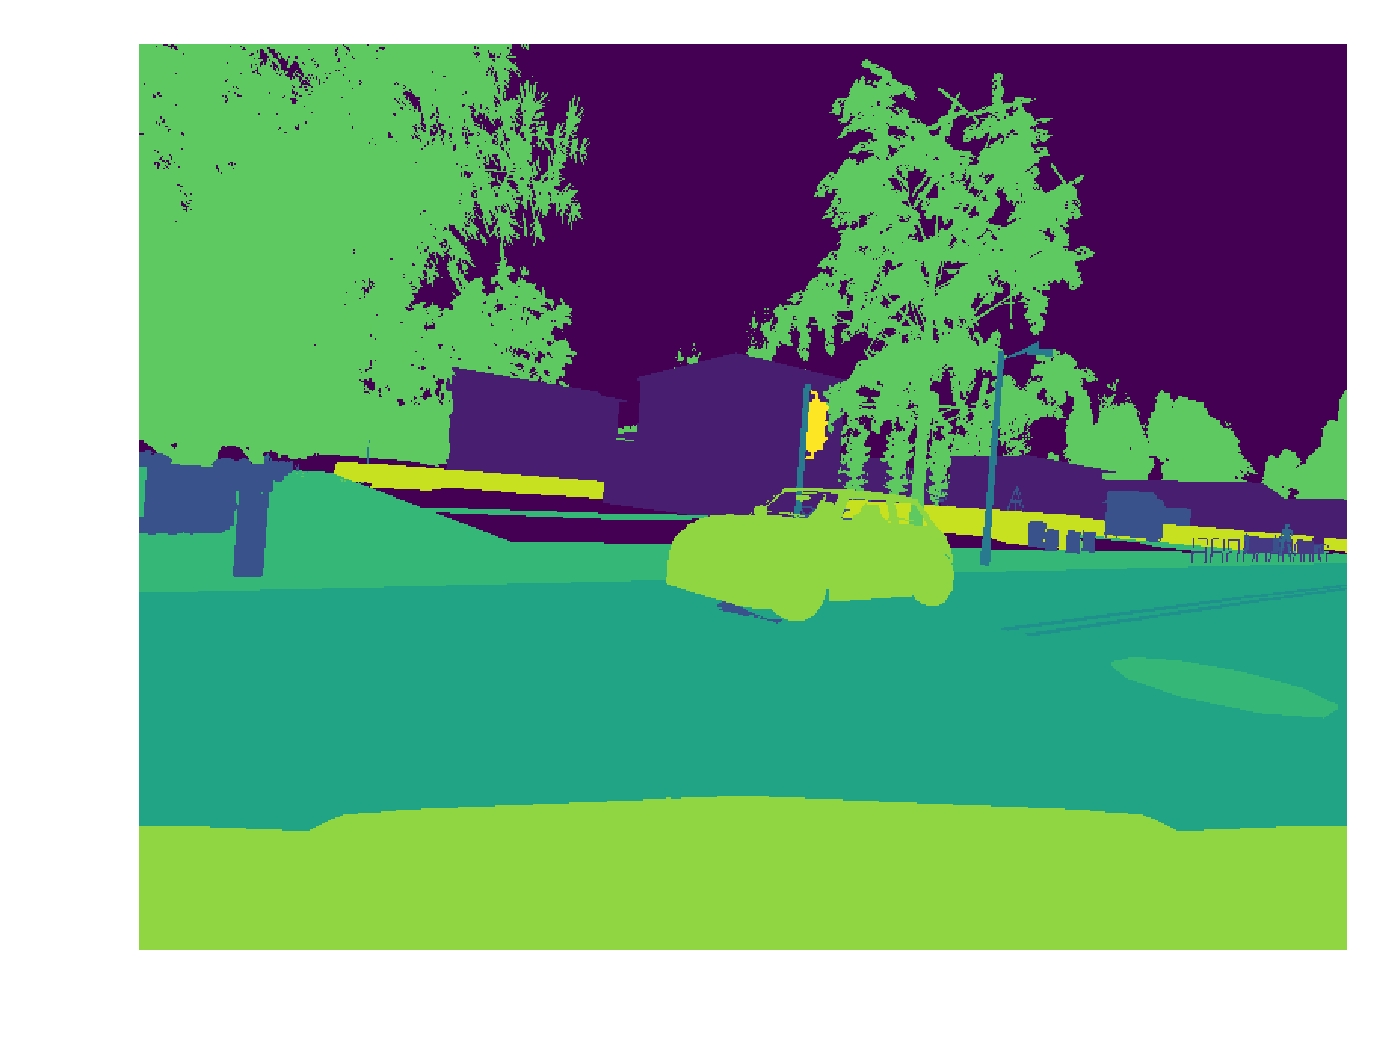

In [4]:
img = cv2.imread('./data/train/CameraRGB/1.png')[:,:,::-1]
trg = cv2.imread('./data/train/CameraSeg/1.png')[:,:,2]
show_img(img)
show_img(trg)

Make and save the hood mask. It contains zeros on the hood and ones elsewhere in order to use it for the hood deduction with a simple logical "and" operation.

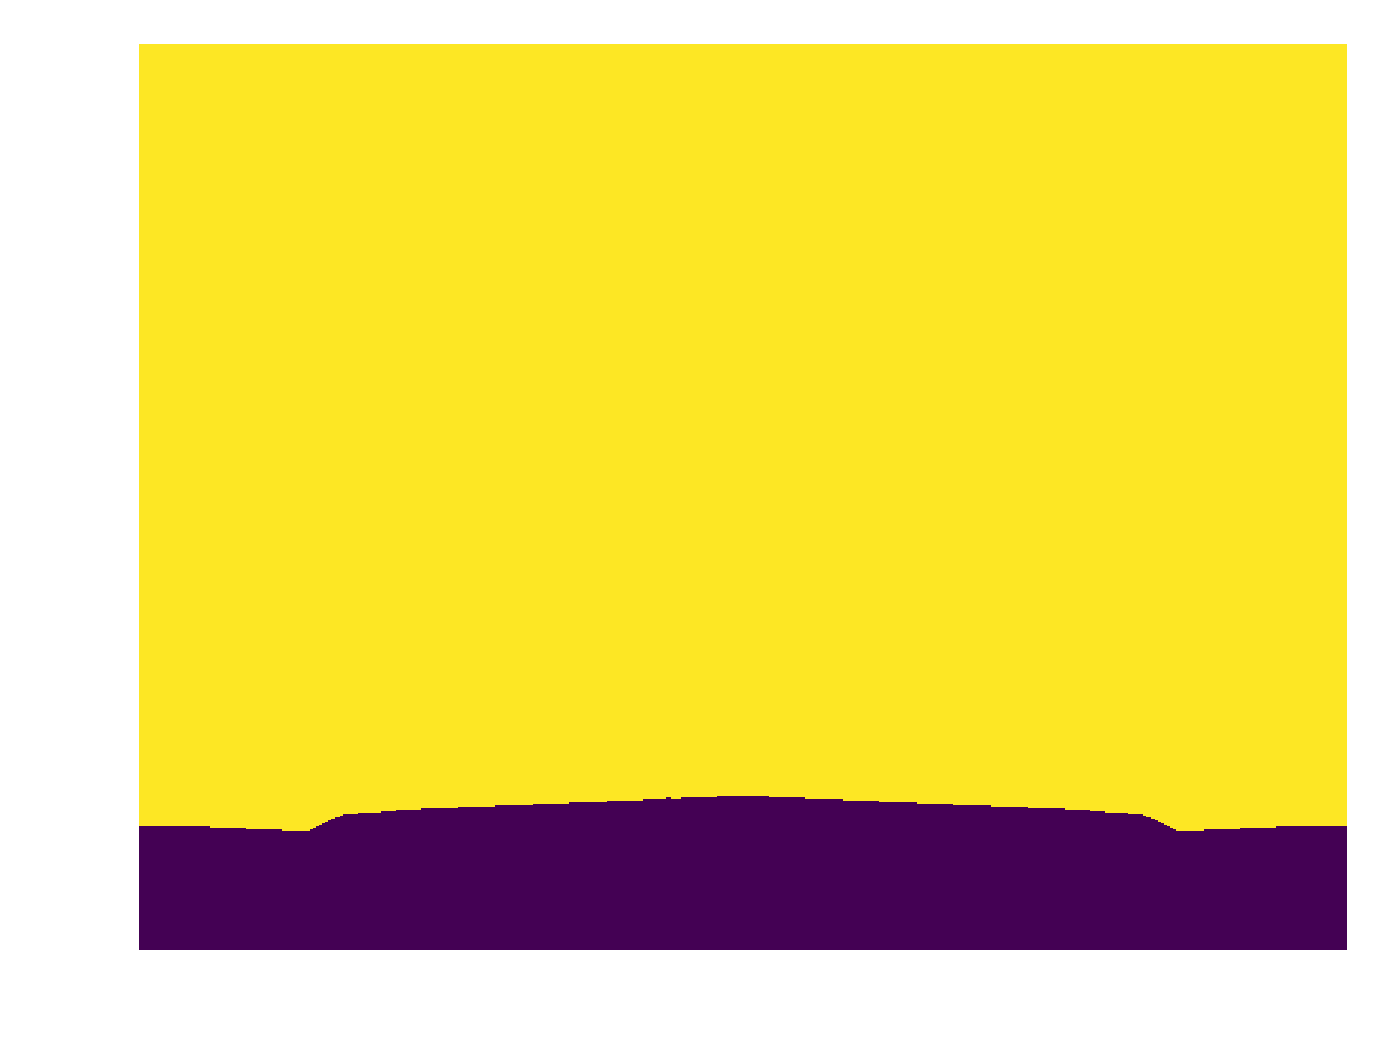

In [5]:
trg = cv2.imread('./data/train/CameraSeg/1.png')
h, w, _ = trg.shape
mask = np.zeros((h+2, w+2, 1), dtype=np.uint8)
hood = cv2.floodFill(trg, mask, (w//2, h-1), (0,1,0))
hood = 1-hood[1][:,:,1]
np.save(hood_path, hood)
show_img(hood)

In [ ]:
train_transform = transforms.Compose([
    ToTensor(),
    AugmentColor(gamma, brightness, colors)
])

val_transform = transforms.Compose([
    ToTensor(),
])

In [ ]:
train_datasets = [LyftDataset(train_dir, hood_path, top, bottom, train_transform, transforms.ToTensor(), False)
                  for train_dir in train_dirs]
train_dataset = ConcatDataset(train_datasets)
print("Train imgs:", train_dataset.__len__())
val_datasets = [LyftDataset(val_dir, hood_path, top, bottom, val_transform, transforms.ToTensor(), False)
                for val_dir in val_dirs]
val_dataset = ConcatDataset(val_datasets)
print("Train imgs:", val_dataset.__len__())

## Input visualization

In [ ]:
for i in range(10):
    for data in train_dataset:
        print(data[0].shape, data[1].shape)
        show_img(np.moveaxis(data[0].cpu().numpy(), 0, -1)[:,:,::-1])
        break

## Model creation

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

In [ ]:
device = torch.device("cuda")

In [ ]:
train_loss = LyftLoss(bce_w=0, car_w=1.0, other_w=1.0).to(device)
val_loss = LyftLoss(bce_w=0, car_w=1, other_w=0).to(device)
model = LinkNet(3, 3, encoder, final).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

Uncomment and enter correct path to load pretrain

In [ ]:
#load_model_path = './data/models/resnet34_001.pth'
#state = torch.load(load_model_path)
#model.load_state_dict(state)

## Train the model

In [ ]:
def val():
    c_loss = 0
    with torch.no_grad():
        for img, trg in val_loader:
            img = img.type(torch.cuda.FloatTensor)
            trg = trg.type(torch.cuda.FloatTensor)
            pred = model(img)
            loss = val_loss(pred, trg)
            c_loss += loss.item()
        c_loss /= val_dataset.__len__()
    return c_loss

def train(epochs):
    losses = []
    best_loss = val()
    print("Start val loss:", best_loss)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        s_time = time.time()
        for img, trg in train_loader:
            # get the inputs
            img = img.type(torch.cuda.FloatTensor)
            trg = trg.type(torch.cuda.FloatTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            pred = model(img)
            loss = train_loss(pred, trg)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        running_loss /= train_dataset.__len__()
        val_s = val()
        print("Epoch:", epoch+1, "train loss:", round(running_loss, 5), "val loss", val_s,
              "val score:", round((2-val_s*batch)/2, 5),
              "time:", round(time.time()-s_time, 2), "s")
        if val_s < best_loss:
            torch.save(model.state_dict(), model_path[:-4]+'_cpt'+model_path[-4:])
            best_loss = val_s
            print("Checkpoint saved")
        losses.append([running_loss, val])
        running_loss = 0.0

In [ ]:
torch.cuda.synchronize()

train(epochs)


print('Finished Training')
torch.save(model.state_dict(), model_path)
print(losses)

## Predictions visualization

In [ ]:
def show_pred(fname):
    img_test = cv2.imread(fname)
    show_img(img_test)
    img_test = np.moveaxis(img_test, -1, 0)[:,top:bottom,:]
    print(img_test.shape)
    img_test = img_test[np.newaxis,:,:]
    img_test = torch.from_numpy(img_test).type(torch.cuda.FloatTensor)
    pred = model(img_test)
    pred = pred.cpu().data[0,:,:,:].numpy()
    pred_img = np.moveaxis(pred, 0, -1)
    pred_f = np.zeros((600,800,3))
    pred_f[:,:,0] = 1
    pred_f[top:bottom,:,:] = pred_img
    show_img(pred_f)
    return pred_f

In [ ]:
idx = 1

pred_img = show_pred('./data/val/CameraRGB/'+str(idx)+'.png')
trg_test = train_datasets[0]._fix_trg(cv2.imread('./data/val/CameraSeg/'+str(idx)+'.png'))
show_img(trg_test)
show_img(np.abs(trg_test-pred_img))  # Diff between prediction and target